# Clustering

Attempting to look at the local distribution around certain fraudulent points.

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [6]:
# Import data
train_processed = pd.read_csv('../data/train_processed_cbm.csv')

target = 'fraud_bool'
X = train_processed.drop(columns = [target])
y = train_processed[target]

In [58]:
X.head()

,income,name_email_similarity,current_address_months_count,customer_age,days_since_request,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,...,housing_status_BG,device_os_linux,device_os_macintosh,device_os_other,device_os_windows,device_os_x11,device_distinct_emails_8w_-1.0,device_distinct_emails_8w_0.0,device_distinct_emails_8w_1.0,device_distinct_emails_8w_2.0
0,-0.851716,1.755983,-0.674654,0.517651,-0.171290,-0.831846,1.877379,1.621305,0.858251,-0.417726,...,-0.023484,1.431536,-0.204533,-0.786949,-0.564550,-0.08849,-0.016717,-0.084548,0.205852,-0.185528
1,0.879421,0.475751,0.040693,-1.091684,-0.170485,-0.382880,0.592602,-0.112964,-0.384216,-0.422069,...,-0.023484,-0.698551,-0.204533,1.270730,-0.564550,-0.08849,-0.016717,-0.084548,0.205852,-0.185528
2,0.879421,1.791367,-0.797604,0.517651,-0.169953,-0.804863,-0.983801,-0.338025,-0.305220,-0.396011,...,-0.023484,-0.698551,-0.204533,-0.786949,1.771323,-0.08849,-0.016717,-0.084548,0.205852,-0.185528
3,0.186966,-0.017937,-0.797604,-0.287017,-0.171228,0.985004,2.320580,0.718954,-0.339709,-0.404697,...,-0.023484,1.431536,-0.204533,-0.786949,-0.564550,-0.08849,-0.016717,-0.084548,0.205852,-0.185528
4,1.225649,1.255797,-0.629945,0.517651,1.202817,0.127546,0.054583,-0.624592,-0.385661,-0.426411,...,-0.023484,-0.698551,-0.204533,1.270730,-0.564550,-0.08849,-0.016717,-0.084548,0.205852,-0.185528


## Perform PCA

Went ahead and did a PCA even though that's probably a bad idea given the one-hot encoded stuff in there.

[0.0551228  0.05310339]


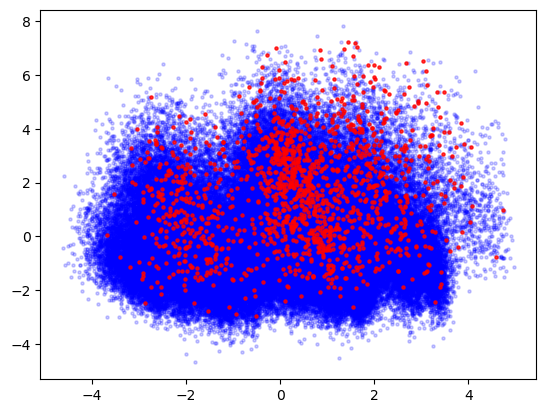

In [31]:
# Try a PCA even though we have one-hot encoded stuff in there
pca = PCA()
pca.fit(X)
# Explained variance from first two PCs
print(pca.explained_variance_ratio_[0:2])

# Plot first two components
X_pca = pca.transform(X)
plt.scatter(X_pca[y == False, 0],
            X_pca[y == False, 1],
            c = "blue",
            s = 5,
            alpha = 0.2)
plt.scatter(X_pca[y == True, 0],
            X_pca[y == True, 1],
            c = "red",
            s = 5,
            alpha = 0.8)

Text(0, 0.5, 'Explained variance')

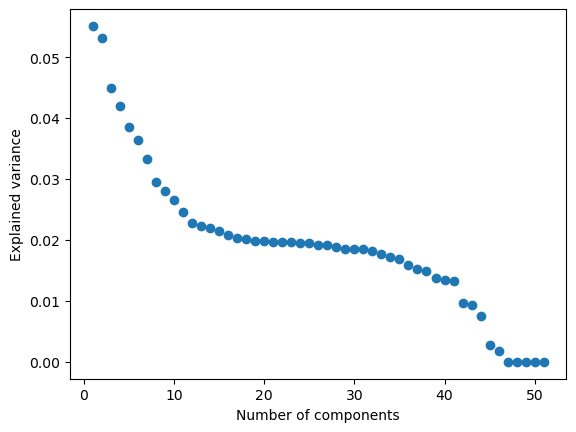

In [32]:
# Let's check out the elbow plot
plt.scatter(x = range(1, len(pca.explained_variance_ratio_) + 1),
                        y = pca.explained_variance_ratio_)
plt.xlabel('Number of components')
plt.ylabel('Explained variance')

There is a big drop after the first two PCs, and maybe an elbow around 10.

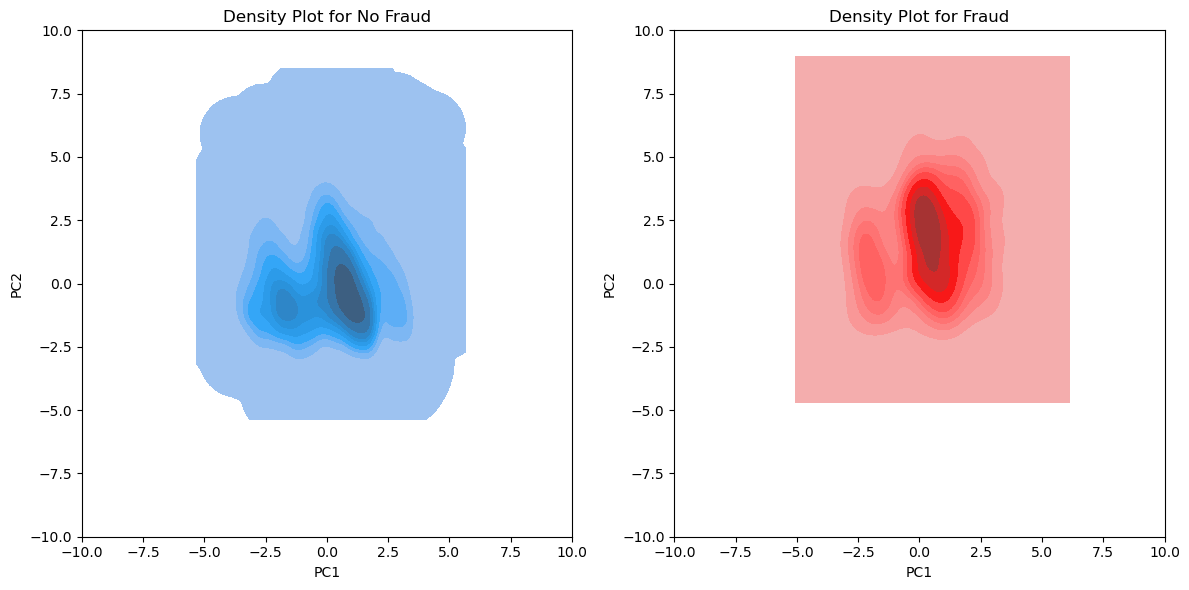

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot KDE for the first dataset
sns.kdeplot(x=X_pca[y == False][:, 0], y=X_pca[y == False][:, 1], fill=True, thresh=0,
           ax=axes[0])
axes[0].set_title('Density Plot for No Fraud')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].set_xlim(-10, 10)  # Adjust the range as needed
axes[0].set_ylim(-10, 10)  # Adjust the range as needed

# Plot KDE for the second dataset
sns.kdeplot(x=X_pca[y == True][:, 0], y=X_pca[y == True][:, 1], fill=True, thresh=0,
           ax=axes[1], color = 'red')
axes[1].set_title('Density Plot for Fraud')
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].set_xlim(-10, 10)  # Adjust the range as needed
axes[1].set_ylim(-10, 10)  # Adjust the range as needed

# Display the plot
plt.tight_layout()
plt.show()


Perhaps the second cluster has slightly different distributions for fraud vs. not fraud?

In [52]:
# Cluster the PCA results
# Using K-means
kmeans_pca = KMeans(n_clusters = 2, random_state=42)
# Use the first 10 components
kmeans_pca.fit(X_pca[:, 0:11])


/home/aw23877/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=2, random_state=42)

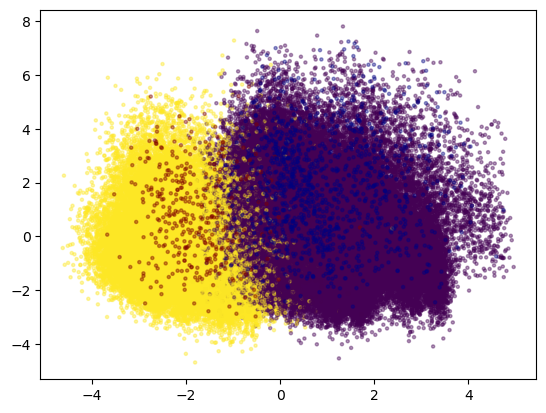

In [53]:
# Visualize the clusters
plt.scatter(X_pca[y == False, 0],
            X_pca[y == False, 1],
            c = kmeans_pca.labels_[y == False],
            s = 5,
            alpha = 0.4,
            cmap = 'viridis')
plt.scatter(X_pca[y == True, 0],
            X_pca[y == True, 1],
            c = kmeans_pca.labels_[y == True],
            s = 5,
            alpha = 0.4,
            cmap = 'jet')

The left cluster is cluster 0, the right cluster is cluster 1.